SAMBUNG KE GDRIVE

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Install keras-tuner
!pip install -q keras-tuner

Mounted at /content/drive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.6 MB/s eta 0:00:00


IMPORT LIBRARY

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array
from tensorflow.keras.utils import load_img
from PIL import ImageOps
import random
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


DATA PREPROCESSING DAN AUGMENTASI

In [ ]:
# Path & params
data_dir = '/content/drive/MyDrive/siswa/label'
img_size = (224, 224)
batch_size = 32


# Data Augmentasi
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=0,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)


train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='training',
    shuffle=True
)

val_generator = datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='validation',
    shuffle=False
)

Found 408 images belonging to 2 classes.
Found 102 images belonging to 2 classes.


MEMPERLIHATKAN URUTAN BINARY LABEL

In [ ]:
print(train_generator.class_indices)

{'neat': 0, 'notneat': 1}


MENAMPILKAN HASIL PREPROCESSING DAN AUGMENTASI


Label: neat - displays  3 images


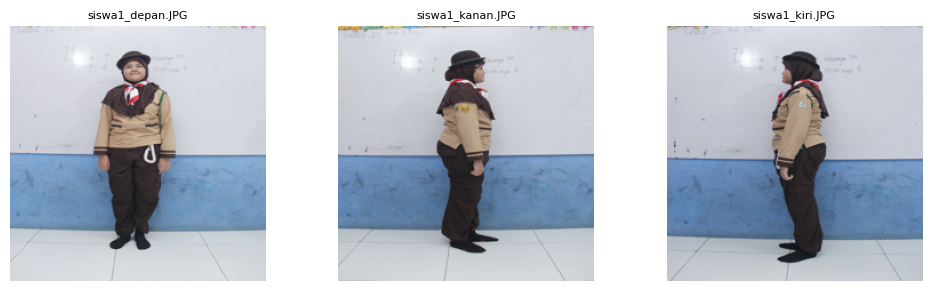


Label: notneat - displays  3 images


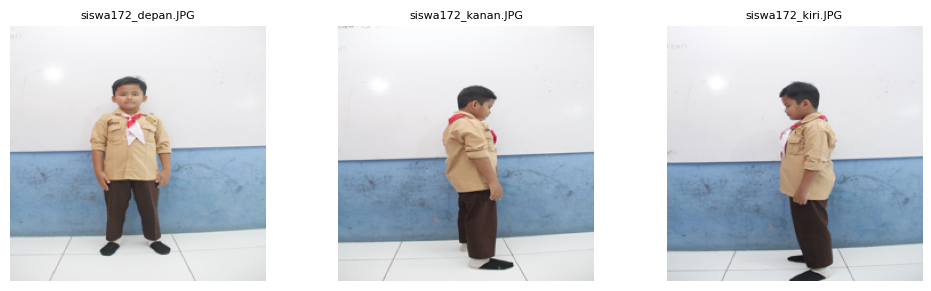

In [ ]:
import os
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from PIL import Image, ImageOps  # Tambahan penting

# Lokasi folder gambar
base_dir = '/content/drive/MyDrive/siswa/label'

# Ukuran gambar target
img_size = (224, 224)

# Ambil semua label
labels = [label for label in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, label))]

# Tampilkan 3 gambar tiap label dengan orientasi benar
for label in labels:
    folder_path = os.path.join(base_dir, label)
    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.jpg', '.png'))][:3]

    print(f"\nLabel: {label} - displays  {len(image_files)} images")

    plt.figure(figsize=(10, 3))
    for i, img_file in enumerate(image_files):
        img_path = os.path.join(folder_path, img_file)

        # Load dengan PIL dan betulkan orientasi
        img = Image.open(img_path)
        img = ImageOps.exif_transpose(img)  # <-- KUNCI: betulkan rotasi
        img = img.resize(img_size)
        img_array = img_to_array(img) / 255.0

        plt.subplot(1, 3, i + 1)
        plt.imshow(img_array)
        plt.title(img_file, fontsize=8)
        plt.axis('off')

    plt.tight_layout()
    plt.show()


MEMBANGUN MODEL CNN DENGAN TRANSFER LEARNING DAN MOBILENETV2

In [ ]:
# Load base MobileNetV2
base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(224,224,3))
base_model.trainable = False  # Freeze awal
from tensorflow.keras.regularizers import l2
# Add custom head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)
callbacks = [early_stop, checkpoint]

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


TRAINING DATA TANPA FINE TUNE

In [ ]:
# Train top layers
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    callbacks=callbacks
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5431 - loss: 0.8272

13/13 ━━━━━━━━━━━━━━━━━━━━ 81s 6s/step - accuracy: 0.5421 - loss: 0.8251 - val_accuracy: 0.6373 - val_loss: 0.6534
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6441 - loss: 0.6267

13/13 ━━━━━━━━━━━━━━━━━━━━ 71s 6s/step - accuracy: 0.6456 - loss: 0.6254 - val_accuracy: 0.6275 - val_loss: 0.6459
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6954 - loss: 0.5566

13/13 ━━━━━━━━━━━━━━━━━━━━ 67s 5s/step - accuracy: 0.6965 - loss: 0.5546 - val_accuracy: 0.6765 - val_loss: 0.6129
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7384 - loss: 0.5240

13/13 ━━━━━━━━━━━━━━━━━━━━ 63s 5s/step - accuracy: 0.7395 - loss: 0.5234 - val_accuracy: 0.6569 - val_loss: 0.5960
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 65s 5s/step - accuracy: 0.8123 - loss: 0.4630 - val_accuracy: 0.6765 - val_loss: 0.6165
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7542 - loss: 0.4540

13/13 ━━━━━━━━━━━━━━━━━━━━ 65s 5s/step - accuracy: 0.7554 - loss: 0.4537 - val_accuracy: 0.6471 - val_loss: 0.5923
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7848 - loss: 0.4722

13/13 ━━━━━━━━━━━━━━━━━━━━ 64s 5s/step - accuracy: 0.7842 - loss: 0.4704 - val_accuracy: 0.6961 - val_loss: 0.5724
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 80s 5s/step - accuracy: 0.8381 - loss: 0.3984 - val_accuracy: 0.6765 - val_loss: 0.6656
Epoch 9/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8199 - loss: 0.4075

13/13 ━━━━━━━━━━━━━━━━━━━━ 74s 6s/step - accuracy: 0.8196 - loss: 0.4077 - val_accuracy: 0.7353 - val_loss: 0.5461
Epoch 10/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 72s 5s/step - accuracy: 0.8061 - loss: 0.4011 - val_accuracy: 0.6667 - val_loss: 0.6063


TRAINING PAKAI FINE TUNE

In [ ]:
# Fine-tune: unfreeze bagian akhir base model
# sudah di run
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False

model.compile(optimizer=tf.keras.,optimizers.Adam(1e-5) loss='binary_crossentropy', metrics=['accuracy'])
fine_tune_history = model.fit(train_generator, epochs=10, validation_data=val_generator)


Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 100s 7s/step - accuracy: 0.7208 - loss: 0.5593 - val_accuracy: 0.6765 - val_loss: 0.6230
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 77s 6s/step - accuracy: 0.7501 - loss: 0.5230 - val_accuracy: 0.6569 - val_loss: 0.6202
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 77s 6s/step - accuracy: 0.7565 - loss: 0.4713 - val_accuracy: 0.6667 - val_loss: 0.6372
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 77s 6s/step - accuracy: 0.7889 - loss: 0.4672 - val_accuracy: 0.6667 - val_loss: 0.6206
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 67s 5s/step - accuracy: 0.8110 - loss: 0.4402 - val_accuracy: 0.6961 - val_loss: 0.5998
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 70s 5s/step - accuracy: 0.8404 - loss: 0.4055 - val_accuracy: 0.6569 - val_loss: 0.6674
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 72s 5s/step - accuracy: 0.8122 - loss: 0.3751 - val_accuracy: 0.6667 - val_loss: 0.6658
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 76s 6s/step - accuracy: 0.8547 - loss: 0.3362 - val_accuracy: 0.6667 - val_loss

EVALUASI MODEL

In [ ]:
# Evaluasi
# sudah di run
val_generator.reset()
preds = model.predict(val_generator)
y_pred = (preds > 0.5).astype(int).reshape(-1)
y_true = val_generator.classes
labels = list(val_generator.class_indices.keys())

4/4 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step


HASIL METRIKS AKURASI

In [ ]:
# Classification Report
# sudah di run
# akurasi rapi 75%
#akurasi tidak rapi 70
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=labels))

Classification Report:

              precision    recall  f1-score   support

        neat       0.81      0.51      0.63        51
     notneat       0.64      0.88      0.74        51

    accuracy                           0.70       102
   macro avg       0.73      0.70      0.69       102
weighted avg       0.73      0.70      0.69       102



MENAMPILKAN HASIL GRAFIK LOSS DAN AKKURASI

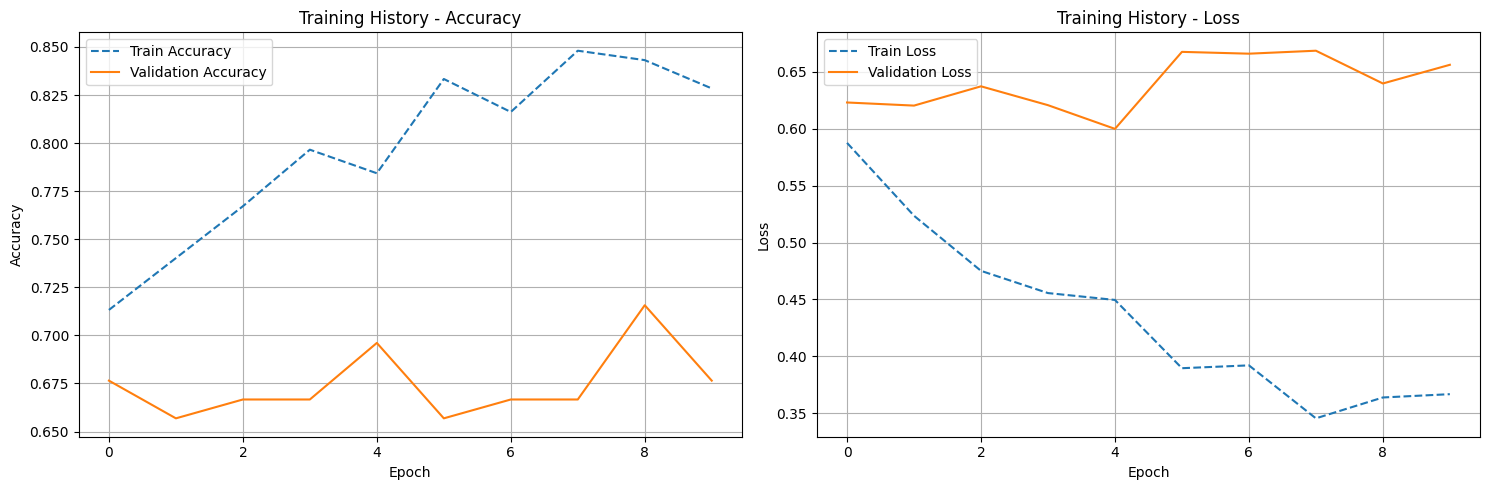

In [ ]:
def plot_full_history(histories, title='Training History'):
    fig, axs = plt.subplots(1, 2, figsize=(15,5))

    # Plot Accuracy
    for label, history in histories.items():
        axs[0].plot(history.history['accuracy'], linestyle='--', label='Train Accuracy')
        axs[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axs[0].set_title(f'{title} - Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Accuracy')
    axs[0].legend()
    axs[0].grid(True)

    # Plot Loss
    for label, history in histories.items():
        axs[1].plot(history.history['loss'], linestyle='--', label='Train Loss')
        axs[1].plot(history.history['val_loss'], label='Validation Loss')
    axs[1].set_title(f'{title} - Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Loss')
    axs[1].legend()
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()

# Panggil hanya fine-tune history tanpa label spesifik
plot_full_history({'Model': fine_tune_history})


GRAFIK CONFUSIONAL METRIKS

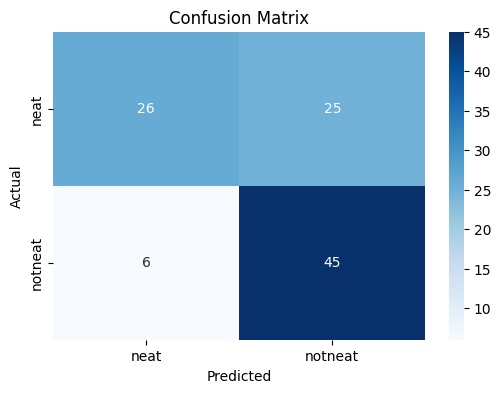

In [ ]:
# Confusion Matrix
# sudah di run
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

UJI INPUT DATA BARU

Saving siswa42_depan.JPG to siswa42_depan.JPG
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


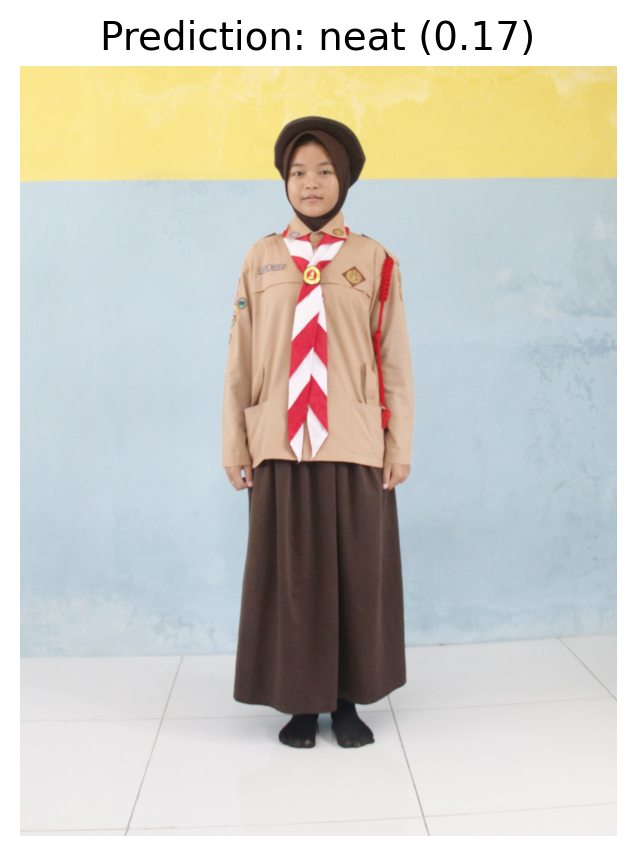

In [ ]:
from google.colab import files
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageOps

# Upload dan ambil path
uploaded = files.upload()
img_path = list(uploaded.keys())[0]

# Load gambar asli dan perbaiki orientasi
img_show = ImageOps.exif_transpose(Image.open(img_path))
img_resized = img_show.resize((224, 224), resample=Image.LANCZOS)

# Preprocessing
img_array = image.img_to_array(img_resized) / 255.0
img_array = np.expand_dims(img_array, axis=0)

# Prediksi
prediction = model.predict(img_array)[0][0]
label = 'notneat' if prediction >= 0.5 else 'neat'

# Tampilkan gambar dengan orientasi benar
plt.figure(figsize=(5,5), dpi=200)
plt.imshow(img_show)
plt.axis('off')
plt.title(f'Prediction: {label} ({prediction:.2f})', fontsize=14)
plt.savefig('hasil_prediksi_hd.png', dpi=300, bbox_inches='tight')
plt.show()
